# <center> Movie Recommendation Systems </center>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from ast import literal_eval
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import SVD, Reader, Dataset
from surprise.model_selection import cross_validate

## Loading Datasets

In [ ]:
df_credits=pd.read_csv('../input/tmdb-movie-metadata/tmdb_5000_credits.csv')

In [ ]:
df_credits.head(2)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


In [ ]:
df_movies=pd.read_csv('tmdb_5000_movies.csv')

In [ ]:
df_movies.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


In [ ]:
df_credits.columns=['id', 'title', 'cast', 'crew']

In [ ]:
df_movies.drop(['title'], axis=1, inplace=True)

In [ ]:
df_movielens=pd.merge(df_credits,df_movies,on='id')

In [ ]:
df_movielens.head(2)

,id,title,cast,crew,budget,genres,homepage,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,vote_average,vote_count
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,7.2,11800
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",6.9,4500


In [ ]:
df_movielens.shape

(4803, 22)

## Demographic Recommender

In [ ]:
df_movielens['vote_average'].mean()

6.092171559442011

In [ ]:
df_filtered=df_movielens[df_movielens['vote_count']>df_movielens['vote_count'].quantile(q=0.9)]

In [ ]:
df_filtered.shape

(481, 22)

In [ ]:
def movie_score(x):
    v=x['vote_count']
    m=df_movielens['vote_count'].quantile(q=0.9)
    R=x['vote_average']
    C=df_movielens['vote_average'].mean()
    return ((R*v)/(v+m))+((C*m)/(v+m))

In [ ]:
df_filtered['score']=df_filtered.apply(movie_score, axis=1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_highscore=df_filtered.sort_values(by='score', ascending=False).head(10)

In [ ]:
df_highscore[['title', 'vote_count', 'vote_average', 'popularity', 'score']]

,title,vote_count,vote_average,popularity,score
1881,The Shawshank Redemption,8205,8.5,136.747729,8.059258
662,Fight Club,9413,8.3,146.757391,7.939256
65,The Dark Knight,12002,8.2,187.322927,7.920020
3232,Pulp Fiction,8428,8.3,121.463076,7.904645
96,Inception,13752,8.1,167.583710,7.863239
3337,The Godfather,5893,8.4,143.659698,7.851236
95,Interstellar,10867,8.1,724.247784,7.809479
809,Forrest Gump,7927,8.2,138.133331,7.803188
329,The Lord of the Rings: The Return of the King,8064,8.1,123.630332,7.727243
1990,The Empire Strikes Back,5879,8.2,78.517830,7.697884


In [ ]:
df_popular= df_movielens.sort_values('popularity', ascending=False).head(10)

In [ ]:
df_popular[['title', 'vote_count', 'vote_average', 'popularity']]

,title,vote_count,vote_average,popularity
546,Minions,4571,6.4,875.581305
95,Interstellar,10867,8.1,724.247784
788,Deadpool,10995,7.4,514.569956
94,Guardians of the Galaxy,9742,7.9,481.098624
127,Mad Max: Fury Road,9427,7.2,434.278564
28,Jurassic World,8662,6.5,418.708552
199,Pirates of the Caribbean: The Curse of the Bla...,6985,7.5,271.972889
82,Dawn of the Planet of the Apes,4410,7.3,243.791743
200,The Hunger Games: Mockingjay - Part 1,5584,6.6,206.227151
88,Big Hero 6,6135,7.8,203.734590


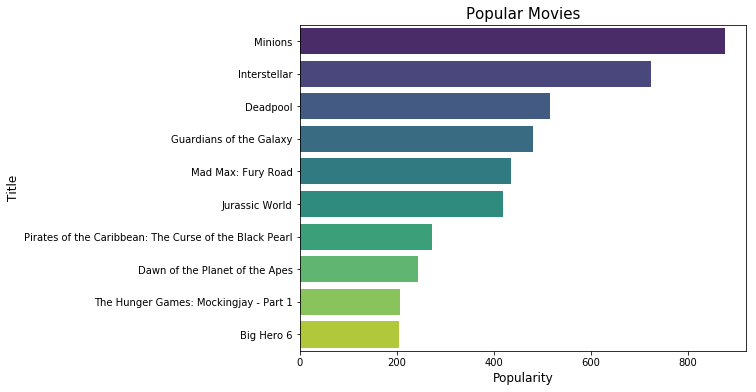

In [ ]:
plt.figure(figsize=(8,6))
sns.barplot(y='title',x='popularity', data=df_popular, palette='viridis')
plt.xlabel("Popularity", fontsize=12)
plt.ylabel("Title", fontsize=12)
plt.title("Popular Movies", fontsize=15)
plt.show()

## Content-Based Recommender

### Movie Overview Based Recommender

First we compute pairwise similarity scores for all movies based on their 'overview' column. Then recommend movies based on that similarity score.

In [ ]:
df_movielens['overview'].head()

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
Name: overview, dtype: object

We replace NaN in 'overview' column with an empty string.

In [ ]:
df_movielens['overview'].isnull().sum()

3

In [ ]:
df_movielens['overview'].fillna(' ', inplace=True)

#### Constructing TF-IDF Matrix

In [ ]:
tfidfv=TfidfVectorizer(analyzer='word', stop_words='english')
tfidfv_matrix=tfidfv.fit_transform(df_movielens['overview'])
print(tfidfv_matrix.todense())
tfidfv_matrix.todense().shape

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


(4803, 20978)

#### Computing Similarity Score

In [ ]:
cosine_sim1 = linear_kernel(tfidfv_matrix, tfidfv_matrix)

In [ ]:
cosine_sim1.shape

(4803, 4803)

#### Defining Recommendation Function

In [ ]:
indices=pd.Series(data=list(df_movielens.index), index= df_movielens['title'] )

In [ ]:
indices.head()

title
Avatar                                      0
Pirates of the Caribbean: At World's End    1
Spectre                                     2
The Dark Knight Rises                       3
John Carter                                 4
dtype: int64

In [ ]:
# Function that takes in movie title as input and outputs most similar movies
def content_recommendations(title, cosine_sim):

    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores.sort(key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores=sim_scores[1:11]

    # Get the movie indices
    ind=[]
    for (x,y) in sim_scores:
        ind.append(x)

    # Return the top 10 most similar movies
    tit=[]
    for x in ind:
        tit.append(df_movielens.iloc[x]['title'])
    return pd.Series(data=tit, index=ind)

In [ ]:
content_recommendations('The Dark Knight Rises',cosine_sim1)

65                              The Dark Knight
299                              Batman Forever
428                              Batman Returns
1359                                     Batman
3854    Batman: The Dark Knight Returns, Part 2
119                               Batman Begins
2507                                  Slow Burn
9            Batman v Superman: Dawn of Justice
1181                                        JFK
210                              Batman & Robin
dtype: object

In [ ]:
content_recommendations('The Avengers',cosine_sim1)

7               Avengers: Age of Ultron
3144                            Plastic
1715                            Timecop
4124                 This Thing of Ours
3311              Thank You for Smoking
3033                      The Corruptor
588     Wall Street: Money Never Sleeps
2136         Team America: World Police
1468                       The Fountain
1286                        Snowpiercer
dtype: object

### Movie Cast, Crew, Keywords, Genres Based Recommender

#### Preprocessing the Contents

##### Applying literal_eval Function on Stringified Lists

In [ ]:
type(df_movielens['cast'].iloc[0])

str

In [ ]:
features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    df_movielens[feature] = df_movielens[feature].apply(literal_eval)

In [ ]:
type(df_movielens['cast'].iloc[0])

list

##### Defining Functions to Grab the Contents

In [ ]:
# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x):
    for a in x:
        if a['job']=='Director':
            return a['name']
    return 'NaN'

In [ ]:
# Get the list top 3 elements or entire list; whichever is more in cast, genres and keywords columns.
def get_top3(x):
    new=[]
    for a in x[:3]:
        new.append(a['name'])
    return new
#Return empty list in case of missing/malformed data
    return []

In [ ]:
df_movielens['director']=df_movielens['crew'].apply(lambda x: get_director(x))

In [ ]:
df_movielens['actor']=df_movielens['cast'].apply(lambda x:get_top3(x))

In [ ]:
df_movielens['genres']=df_movielens['genres'].apply(lambda x:get_top3(x))

In [ ]:
df_movielens['keywords']=df_movielens['keywords'].apply(lambda x:get_top3(x))

In [ ]:
df_movielens[['title', 'actor', 'director', 'keywords', 'genres']].head(3)

,title,actor,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"


In [ ]:
def clean_director(x):
    return x.lower().replace(' ','')

In [ ]:
def clean_top3(x):
    new=[]
    for a in x:
        new.append(a.lower().replace(' ',''))
    return new

In [ ]:
df_movielens['director']=df_movielens['director'].apply(lambda x: clean_director(x))

In [ ]:
df_movielens['actor']=df_movielens['actor'].apply(lambda x:clean_top3(x))

In [ ]:
df_movielens['keywords']=df_movielens['keywords'].apply(lambda x:clean_top3(x))

In [ ]:
df_movielens['genres']=df_movielens['genres'].apply(lambda x:clean_top3(x))

In [ ]:
df_movielens[['title', 'actor', 'director', 'keywords', 'genres']].head(3)

,title,actor,director,keywords,genres
0,Avatar,"[samworthington, zoesaldana, sigourneyweaver]",jamescameron,"[cultureclash, future, spacewar]","[action, adventure, fantasy]"
1,Pirates of the Caribbean: At World's End,"[johnnydepp, orlandobloom, keiraknightley]",goreverbinski,"[ocean, drugabuse, exoticisland]","[adventure, fantasy, action]"
2,Spectre,"[danielcraig, christophwaltz, léaseydoux]",sammendes,"[spy, basedonnovel, secretagent]","[action, adventure, crime]"


In [ ]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['actor']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])

In [ ]:
df_movielens['soup'] = df_movielens.apply(create_soup, axis=1)

#### Constructing TF-IDF Matrix

In [ ]:
cv = CountVectorizer(stop_words='english')
cv_matrix = cv.fit_transform(df_movielens['soup'])

#### Computing Similarity Score

In [ ]:
cosine_sim2 = cosine_similarity(cv_matrix, cv_matrix)

#### Applying Recommendation Function

In [ ]:
content_recommendations('The Dark Knight Rises', cosine_sim2)

65               The Dark Knight
119                Batman Begins
4638    Amidst the Devil's Wings
1196                The Prestige
3073           Romeo Is Bleeding
3326              Black November
1503                      Takers
1986                      Faster
303                     Catwoman
747               Gangster Squad
dtype: object

In [ ]:
content_recommendations('The Godfather', cosine_sim2)

867      The Godfather: Part III
2731      The Godfather: Part II
2649           The Son of No One
1525              Apocalypse Now
4638    Amidst the Devil's Wings
1018             The Cotton Club
1170     The Talented Mr. Ripley
1209               The Rainmaker
1394               Donnie Brasco
1850                    Scarface
dtype: object

## Collaborative Recommender

In [ ]:
from surprise import SVD, Reader, Dataset
from surprise.model_selection import cross_validate

In [ ]:
df_rating= pd.read_csv('../input/the-movies-dataset/ratings_small.csv')
df_rating.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


### SVD: Matrix Factorization Based Algorithm

In [ ]:
# We will use the famous SVD algorithm.
svd = SVD()

In [ ]:
reader = Reader()

In [ ]:
# Load the ratings_small dataset (download it if needed),
data = Dataset.load_from_df(df_rating[['userId', 'movieId', 'rating']], reader)

In [ ]:
# Run 5-fold cross-validation and print the results
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9014  0.8950  0.8984  0.8947  0.8928  0.8964  0.0030  
MAE (testset)     0.6946  0.6888  0.6911  0.6879  0.6886  0.6902  0.0024  
Fit time          9.06    9.19    9.16    9.11    9.09    9.12    0.05    
Test time         0.26    0.27    0.26    0.38    0.26    0.29    0.05    


{'test_rmse': array([0.90137142, 0.89499551, 0.89836255, 0.89471757, 0.89279701]),
 'test_mae': array([0.6945616 , 0.68884097, 0.69108399, 0.68788139, 0.6885702 ]),
 'fit_time': (9.055752515792847,
  9.19143033027649,
  9.164739608764648,
  9.114232540130615,
  9.087774753570557),
 'test_time': (0.2631540298461914,
  0.2651093006134033,
  0.26421117782592773,
  0.3769676685333252,
  0.2597062587738037)}

In [ ]:
#sample full trainset
trainset = data.build_full_trainset()

In [ ]:
# Train the algorithm on the trainset
svd.fit(trainset)

In [ ]:
df_rating[df_rating['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [ ]:
# predict ratings for the testset
svd.predict(uid=1, iid=302, r_ui=None)

Prediction(uid=1, iid=302, r_ui=None, est=2.5230541821358132, details={'was_impossible': False})

In [ ]:
# directly grab the estimated ratings for the testset
svd.predict(uid=1, iid=302, r_ui=None).est

2.5230541821358132